In [80]:
from __future__ import division
import numpy as np
import matplotlib
from scipy.signal import welch, periodogram, butter, sosfiltfilt
from dynesty import NestedSampler
from dynesty.utils import resample_equal
import corner

font = {'weight' : 'bold', 'size'   : 12}

import matplotlib
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (8, 6)
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from src.makeLISAdata import LISAdata

### Recover sigma in time domain

In [81]:
def time_domain(tsig=2.5, fs=256, dur=10, doplot=0):

    nperseg = int(fs*dur)

    data = np.random.normal(scale=tsig, size=nperseg)

    if doplot:
        sig_vals = np.linspace(0.1*tsig, 10*tsig, 10000)

        loglike = np.zeros(sig_vals.shape)

        for ii in range(sig_vals.size):
            loglike[ii] = -0.5*np.sum(data**2/(sig_vals[ii]**2) + np.log(2*np.pi*(sig_vals[ii])**2))
    

        like = np.exp(loglike - loglike.max())
        plt.plot(sig_vals, like, color='b')
        plt.axvline(tsig, color='r', label='true std')
        plt.xlim(0.98*tsig, 1.02*tsig)
        plt.xlabel('std of data')
        plt.ylabel('likelihood')
        plt.legend()
    return data    
################################################################
data = time_domain(tsig=2.5, fs=1024, dur=100, doplot=0)

### Now recover sigma in freq domain

In [116]:
##First bandpass
def freq_domain(tsig=3, fmin=10, fmax=100, fs=256, diagplot=0, dur=10):
    
    nperseg = int(fs*dur)

    
    ## determine pass band frequencies which are to be slightly higher
    fmin_pass, fmax_pass = int(0.5*fmin), int(1.1*fmax) 
    
    ## get time domain data
    data = time_domain(tsig=tsig, fs=fs, dur=dur, doplot=0)
    


    ## FFT
    hwin = np.hanning(data.size)
    win_fact = np.mean(hwin**2)
    rtilda = np.sqrt(2/(dur*win_fact*fs**2)) * np.fft.rfft(data*hwin, n=nperseg)
    freqs = np.fft.rfftfreq(nperseg, d=1.0/fs)
    fidx = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs, rtilda = freqs[fidx], rtilda[fidx]

    psd_theor = 2*tsig**2/fs
    if diagplot:
        fi, si = welch(data, fs=fs, nperseg=int(1*fs))
        plt.semilogy(fi, si)
        plt.semilogy(freqs, np.abs(rtilda)**2)
        plt.axhline(psd_theor, color='r')
        plt.ylim(3e-1, 2)
        
    return freqs, rtilda, psd_theor
#################################################################################

freqs, rtilda, psd_theor = freq_domain(tsig=13.56, fmin=5, fmax=200, fs=512, diagplot=0)

In [141]:
class Bayes():
    
    def __init__(self, tsig, fmin, fmax, fs, dur):
    
        self.dur, self.fs = dur, fs
        self.fmin, self.fmax = fmin, fmax
        self.tsig = tsig
    
        self.freqs,self.rtilda,self.psd_theor = freq_domain(tsig=self.tsig, fmin=self.fmin, \
                                                            fmax=self.fmax, fs=self.fs, diagplot=0, dur=self.dur)
    
    ## prior function
    def prior(self, theta):
    
        alpha, Sh = theta

        return (-5+10*alpha, 2*self.psd_theor*Sh) 
    
    ## likelihood
    def loglike(self, theta):
    
        alpha, Sh = theta
    
        Sh = Sh*(self.freqs)**alpha
        #import pdb; pdb.ste_trace()
        loglike = -np.sum(np.abs(self.rtilda)**2/(Sh) + np.log(2*np.pi*Sh))
    
        return loglike

In [144]:
def analysis(dur=10):
    
    spectra = Bayes(tsig=4, fmin=1e-4, fmax=1e-1, fs=0.4, dur=dur)
    
    parameters = [r'$S_h$', r'$\alpha$']
    npar = len(parameters)
    
    ## Run sampler
    engine = NestedSampler(spectra.loglike, spectra.prior, npar, bound='multi', sample='rwalk', nlive=100)
    engine.run_nested(dlogz=0.5,print_progress=True )

    # re-scale weights to have a maximum of one
    res = engine.results
    weights = np.exp(res['logwt'] - res['logz'][-1])
    weights[-1] = 1 - np.sum(weights[0:-1])

    post = resample_equal(res.samples, weights)
    truevals = [0, spectra.psd_theor]
    if 1:
        
        fig = corner.corner(post, range=[0.999]*npar, labels=parameters, quantiles=(0.16, 0.84),
                            smooth=None, smooth1d=0.8, show_titles=True,
                            title_kwargs={"fontsize": 12},label_kwargs={"fontsize": 14},
                            fill_contours=True, use_math_text=True, )
        fig.set_size_inches(10, 8)
        
        axes = np.array(fig.axes).reshape((npar, npar))
        
        for ii in range(npar):     
            ax = axes[ii, ii]
            ax.axvline(truevals[ii], color="g", label='true value')
        
        
    else:           

        for ii in range(npar):
            plt.subplots(npar, 1, ii + 1)
            plt.hist(post[:, ii], bins=25, histtype='step')
            plt.axvline(truevals[ii], color="g", label='true value')

##################################################

iter: 1634+100 | bound: 312 | nc: 1 | ncall: 35084 | eff(%):  4.942 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/- 113.781 | dlogz:  0.004 >  0.500            

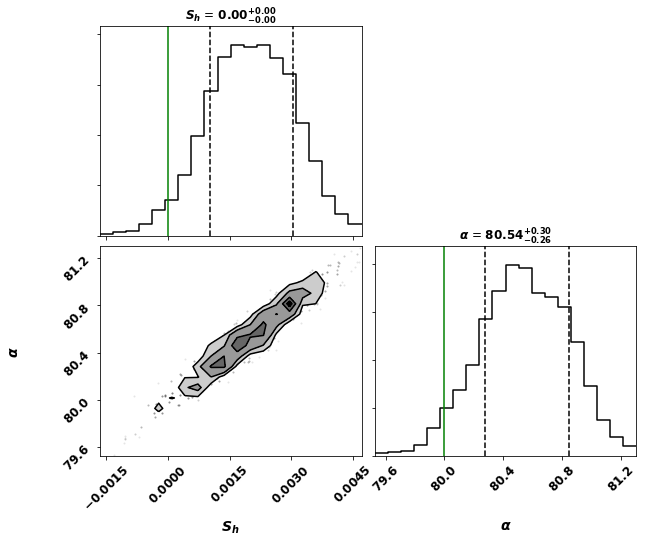

In [147]:
analysis(dur=1e7)